In [41]:
import sys,os
import glob
import torch,dill
import torchvision.utils as vutils
import matplotlib.pyplot as plt
from iresnet import iResBlock
from spectral_norm import SN
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

In [42]:
paths = glob.glob(os.path.expanduser('~/tb-experiments/iresnet_inv_test/**/*.trainer'),recursive=True)
print(paths)

['/home/marc/tb-experiments/iresnet_inv_test/CIFAR10/iResnet/s0.5/trial0/checkpoints/c10.trainer']


In [43]:
trainer = torch.load(paths[-1],pickle_module=dill)
trainer.model.eval();

In [44]:
def singularValues(kernel,input_shape):
    transforms = np.fft.fft2(kernel,input_shape,axes=(0,1))
    return np.linalg.svd(transforms,compute_uv=False)

In [76]:
h = 32
channels = 32
s = []

for module in trainer.model[1].modules():
    if isinstance(module,SN):
        s_ = module._s
    if isinstance(module,nn.Conv2d):
        if module.weight.shape[0]>channels:
            h//=2
            channels = module.weight.shape[0]
        w = module.weight.cpu().data.clone()/torch.max(s_.cpu(),torch.tensor(1.))
#         w2 = F.pad(w,(0,h-3,0,h-3))
#         print(w2.shape)
        #w2_np  =w2.data.numpy()
        # 3 x 3 x c x c
        s.append(np.random.choice(singularValues(w.data.permute((2,3,0,1)).numpy(),(h,h)).reshape(-1),300))

Text(0, 0.5, 'Eigenvalues')

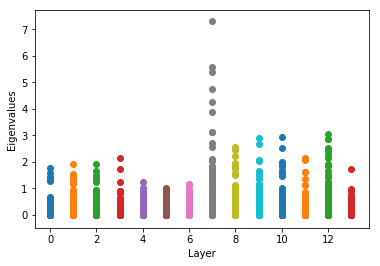

In [80]:
for i in range(len(s)):
    singulars = s[i].reshape(-1)
    plt.scatter(i*np.ones_like(singulars),singulars)
plt.xlabel("Layer")
plt.ylabel(r"Eigenvalues")